In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from tqdm import tqdm
from jqdatasdk import *
auth('18742013305','zcJQ6666')
import matplotlib.pyplot as plt

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
raw_stock = pd.read_csv('minute_close.csv');

In [3]:
raw_volume = pd.read_csv('minute_volume.csv');

In [4]:
raw_stock.index = raw_stock['time'];
raw_volume.index = raw_volume['time'];
raw_stock

,time,010107,010303,010504,010512,010619,018002,018003,018005,018006,...,900945,900946,900947,900948,900951,900952,900953,900955,900956,900957
time,,,,,,,,,,,,,,,,,,,,,
201901020925,201901020925,102.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.179,NaN,NaN,NaN,NaN,NaN,NaN
201901020930,201901020930,102.89,100.67,NaN,NaN,NaN,NaN,NaN,100.40,102.14,...,NaN,0.297,0.339,1.175,NaN,NaN,NaN,0.34,NaN,NaN
201901020931,201901020931,102.85,100.68,NaN,NaN,NaN,NaN,NaN,100.38,NaN,...,NaN,NaN,0.339,1.173,NaN,NaN,NaN,NaN,NaN,NaN
201901020932,201901020932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.91,...,NaN,NaN,NaN,1.175,NaN,NaN,NaN,NaN,NaN,NaN
201901020933,201901020933,102.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.297,NaN,1.175,NaN,NaN,0.502,0.34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201903291525,201903291525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201903291526,201903291526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201903291527,201903291527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#data cleaning
#删掉矩阵中非股票的元素
list_of_stocks = list(get_all_securities(types=['stock'], date='2019-02-02').index)
list_of_stocks_drop_latter_str = [stock_name[:-5] for stock_name in list_of_stocks]
stock_list_after_data_cleaning =list(set(raw_stock.columns) & set(list_of_stocks_drop_latter_str))
volume_list_after_data_cleaning =list(set(raw_volume.columns) & set(list_of_stocks_drop_latter_str))
minute_volume = raw_volume[stock_list_after_data_cleaning]
minute_close = raw_stock[volume_list_after_data_cleaning]

#填充NA数据
minute_close = minute_close.fillna(method='pad');
#minute_close = minute_close.fillna(method='bfill');
minute_volume = minute_volume.fillna(0);
#print(minute_close)

#将time转化为timestamp格式
all_time = []
for ii in minute_close.index.values:
    year = ii//100000000;
    month = ii//1000000-year*100;
    day = ii//10000-year*10000-month*100;
    hour = ii//100-year*1000000-month*10000-day*100;
    minute = ii%100;
    all_time.append(pd.Timestamp(dt(year,month,day,hour,minute)));
minute_close.index = all_time
minute_volume.index = all_time

#删除盘后空白数据
true_false_list_of_time =[not(time.minute>0 and time.hour==15) for time in minute_close.index];
minute_close = minute_close[true_false_list_of_time];
minute_volume= minute_volume[true_false_list_of_time];
#print(minute_close.index)

#上午10点和11点，下午1.30和2.30一天交易四次，只保留交易时间信息以减轻运算压力
deal_time = []
for ii in all_time:
    if (ii.hour==10 and ii.minute==0) or (ii.hour==11 and ii.minute==0) or (ii.hour==13 and ii.minute==30) or (ii.hour==14 and ii.minute==30):
        deal_time.append(ii);
#print(deal_time)
deal_minute_close = minute_close.loc[deal_time,:]
deal_minute_volume= minute_volume.loc[deal_time,:]

In [44]:
#上午10点和11点，下午1.30和2.30一天交易四次，只保留交易时间信息以减轻运算压力
deal_time = []
for ii in all_time:
    if (ii.hour==10 and ii.minute==0) or (ii.hour==11 and ii.minute==0) or (ii.hour==13 and ii.minute==30) or (ii.hour==14 and ii.minute==30):
        deal_time.append(ii);
#print(deal_time)
deal_minute_close = minute_close.loc[deal_time,:]
deal_minute_volume= minute_volume.loc[deal_time,:]
print(deal_minute_close)
print(minute_close)

                     600458  600568  600732  600833  601163  600735  600129  \
2019-01-02 10:00:00    6.84    2.31    4.67    9.10   11.15    5.23    8.38   
2019-01-02 11:00:00    6.84    2.33    4.65    9.01   11.12    5.25    8.41   
2019-01-02 13:30:00    6.84    2.32    4.61    9.09   11.13    5.20    8.35   
2019-01-02 14:30:00    6.89    2.33    4.61    9.01   11.14    5.25    8.36   
2019-01-03 10:00:00    6.95    2.34    4.67    8.93   11.23    5.27    8.34   
...                     ...     ...     ...     ...     ...     ...     ...   
2019-03-28 14:30:00    8.73    2.64    5.87   11.37   13.21    7.31   10.91   
2019-03-29 10:00:00    8.64    2.61    5.82   10.88   12.94    7.22   10.71   
2019-03-29 11:00:00    8.74    2.67    5.87   11.09   13.17    7.32   10.95   
2019-03-29 13:30:00    9.06    2.68    5.91   11.33   13.30    7.70   11.13   
2019-03-29 14:30:00    9.13    2.70    5.89   11.36   13.34    7.72   11.05   

                     603558  601838  603980  ...  6

In [177]:
class HighFrequencyTrade:
    def __init__(self,initCapital,stockPrice):
        self.stockPrice = stockPrice;#分钟级交易价格矩阵
        self.currCapital = initCapital;#资本量，包括股票和现金
        self.currMoney = initCapital;
        self.currPosition = {};
        self.allPosition = {};
        self.dailyPNL=pd.DataFrame(columns=['pnl']);
        self.startdate = pd.Timestamp(stockPrice.index.values[0]);
        self.enddate = pd.Timestamp(stockPrice.index.values[-1]);
        self.Skewness = pd.DataFrame();
        self.factor178Matrix = {};
    def getFactor178(self,price,volume,timeprice):
        #(CLOSE-DELAY(CLOSE,1))/DELAY(CLOSE,1)*VOLUME
        #这里的price和volume是所有时刻的矩阵，我们只想计算一天内四个时刻的factor178的值，因此用timeprice引入这四个交易时间
        factor178Matrix = pd.DataFrame(np.random.randn(timeprice.shape[0],timeprice.shape[1]));
        factor178Matrix.index = timeprice.index;
        factor178Matrix.columns = timeprice.columns;
        for stock in timeprice.columns.values:
            for ii in range(4):
                factor178Matrix.loc[timeprice.index[ii],stock] = price.loc[timeprice.index[ii],stock]
            for ii in range(4,timeprice.shape[0]):
                factor178 = (price.loc[timeprice.index[ii],stock]-price.loc[timeprice.index[ii-4],stock])/price.loc[timeprice.index[ii-4],stock]*volume.loc[timeprice.index[ii],stock];
                factor178Matrix.loc[timeprice.index[ii],stock] = factor178;
            #print(factor178Matrix.loc[:,stock])
        self.factor178Matrix = factor178Matrix;
        return self.factor178Matrix;
    def getSkewness(self,df,timedf,lookbackday):
    #df包含多天的分钟级价格数据,timedf 用于挑出每日交易时间计算偏度，否则计算量过大
        self.Skewness = pd.DataFrame(np.random.randn(timedf.shape[0],timedf.shape[1]));
        self.Skewness.index = timedf.index;
        self.Skewness.columns = timedf.columns;
        securityID = df.columns.values.tolist();
        #print(securityID);
        for stock in tqdm(securityID):
            #计算skewness
            allPrice = df[stock];
            T1Return = pd.DataFrame(np.random.randn(allPrice.shape[0],1));
            T1Return.index = df.index;
            #T1Return为日内一分钟对数收益序列
            index = 1;
            while index<df.shape[0]:
                T1Return.iloc[index] =np.log(allPrice.iloc[index]/allPrice.iloc[index-1]);
                index+=1;
            #intervalday指的是计算偏度需回溯天数,这里默认是分钟单位的数据
            for timeindex in timedf.index:
                temp1 = 0;
                temp2 = 0;
                indexnum = df.index.get_loc(timeindex);
                if timedf.index.get_loc(timeindex)<lookbackday*4:
                    self.Skewness.loc[timeindex,stock] = 0;
                else:
                    for i in range(lookbackday):
                        temp1=temp1+T1Return.iloc[indexnum-i*60*4,0]**3;
                        temp2=temp2+T1Return.iloc[indexnum-i*60*4,0]**2;
                    skewness = lookbackday**0.5*temp1/(temp2**(3/2));
                    #print(skewness)
                    self.Skewness.loc[timeindex,stock] = skewness;
            '''timeindex = lookbackday*60*4;
            while timeindex<df.shape[0]:
                temp1 = 0;
                temp2 = 0;
                timedf.index[timeindex]
                for i in range(lookbackday):
                    temp1=temp1+T1Return.iloc[timeindex*60-i*60*4,0]**3;
                    temp2=temp2+T1Return.iloc[timeindex-i*60*4,0]**2;
                skewness = lookbackday**0.5*temp1/(temp2**(3/2));
                #print(skewness)
                self.Skewness.loc[df.index[timeindex],stock] = skewness;
                timeindex+=1;'''
            self.Skewness = self.Skewness.fillna('pad')#用前一个非缺失值去填充该缺失值
        for i in range(lookbackday*60*4):
            self.Skewness.iloc[i,:]=0;
        print(self.Skewness)
        return Skewness
    def generateFactor178Signal(self,time):#time是timestamp格式
        #判断买入信号
        stockInfo = self.factor178Matrix.loc[time];#这里的timestamp格式最后修改,将一行的股票转化为列以便排序
        #print(stockInfo)
        stockInfo = stockInfo.sort_values(ascending=True);
        #得到该时刻178 factor从大到小排序对应的股票名称
        stockList = list(stockInfo.index);
        tradeSignal = stockList[0:10];
        #print(stockInfo)
        return tradeSignal;
    def generateSkewnessSignal(self,time):#time是timestamp格式
        #判断买入信号
        stockInfo = self.Skewness.loc[time];#这里的timestamp格式最后修改,将一行的股票转化为列以便排序
        #print(stockInfo)
        stockInfo.sort_values(ascending=True);
        #得到该时刻偏度值从小到大排序对应的股票名称
        stockList = list(stockInfo.index);
        tradeSignal = stockList[0:10];
        return tradeSignal;#开仓信号由过去20天偏度决定，每1小时更新一次
    def closePosition(self,time):
        for stock in self.currPosition:
            #用到了时刻价格矩阵,命名为stockPrice
            price = self.stockPrice.loc[time,stock]
            self.currMoney+=price*self.currPosition[stock]*0.998;
        self.currPosition = {};
    def openPosition(self,tradeSignal,currTime):#这里的currTime是csv里面的长串形式
        index=self.stockPrice.index.get_loc(currTime);
        operatestock = tradeSignal;
        hitMoney = self.currMoney*0.6;#拿出现金中的60%用于交易
        for ii in operatestock:
            self.currPosition[ii] = hitMoney/len(operatestock)/self.stockPrice.loc[currTime,ii]//100*100;
            self.currMoney-=self.currPosition[ii]*self.stockPrice.loc[currTime,ii];
        self.allPosition[currTime] = operatestock;
        #print(self.currPosition)
    def constructPNL(self):
        #print(alldate)
        self.dailyPNL=pd.DataFrame(np.random.rand(self.stockPrice.shape[0]//60,1));
        alldate = []
        for name,group in Skewness.groupby(Skewness.index.date):
            alldate.append(name)
        self.dailyPNL.index=alldate;
        self.dailyPNL.columns = ['pnl'];
    def accountPNL(self,time):
        self.currCapital=self.currMoney;
        for ii in self.currPosition:
            self.currCapital+=self.currPosition[ii]*self.stockPrice.loc[time,ii]*0.998;
        self.dailyPNL.loc[time.strftime("%Y-%m-%d"),'pnl']=self.currCapital;
        #print(self.dailyPNL)
        return self.dailyPNL;
    def run(self):
        #一日交易四次，时间节点为10点，11点，下午1:30 2:30
        ii=0;
        for name, group in self.stockPrice.groupby(self.stockPrice.index.date):
            #print('In the date %s'%name)
            dailyPrice = group; 
            if self.Skewness.empty:
                for ii in range(4):
                    dealtime = dailyPrice.iloc[dailyPrice.shape[0]//8*(2*ii+1)+1,:].name;
                    #print(dealtime)
                    signal = self.generateFactor178Signal(dealtime);
                    self.closePosition(dealtime);
                    self.openPosition(signal,dealtime);
                    ss = self.accountPNL(dealtime);
            else:
                    dealtime = dailyPrice.iloc[dailyPrice.shape[0]//8*(2*ii+1)+1,:].name;
                    #print(dealtime)，使用skewness时dealtime还需要调整
                    signal = self.generateSkewnessSignal(dealtime);
                    self.closePosition(dealtime);
                    self.openPosition(signal,dealtime);
                    ss = self.accountPNL(dealtime);
        #print(ss)
        '''fig,ax=plt.subplots(1,1)
        ax.plot(ss.index,ss,label='pnl')
        ax.set_title('daily trade',fontsize=12,color='r')
        tick_spacing = 10
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        plt.tight_layout()'''
        ss.plot()
        print(self.allPosition)

In [46]:
sample = HighFrequencyTrade(100000,minute_close)
Factor178matrix = sample.getFactor178(minute_close,minute_volume,deal_minute_close)
print(Factor178matrix)#难算的矩阵可以放在class初始函数里面以备复用

                          600458       600568      600732       600833  \
2019-01-02 10:00:00     6.840000     2.310000    4.670000     9.100000   
2019-01-02 11:00:00     6.840000     2.330000    4.650000     9.010000   
2019-01-02 13:30:00     6.840000     2.320000    4.610000     9.090000   
2019-01-02 14:30:00     6.890000     2.330000    4.610000     9.010000   
2019-01-03 10:00:00   249.269006   167.532468    0.000000  -183.076923   
...                          ...          ...         ...          ...   
2019-03-28 14:30:00   -87.202718 -1050.185874   -5.912162   109.026549   
2019-03-29 10:00:00  -160.824742 -3651.492537 -333.502538 -3591.065292   
2019-03-29 11:00:00  -162.895928  -222.014925  -67.790894  -170.198105   
2019-03-29 13:30:00  1440.537931   114.339623    0.000000  -500.435540   
2019-03-29 14:30:00  2982.817869  1579.545455    6.814310   -59.982410   

                          601163       600735       600129      603558  \
2019-01-02 10:00:00    11.150000     

{Timestamp('2019-01-02 10:00:00'): ['601558', '600074', '600747', '600157', '601258', '600010', '600022', '603077', '600321', '600166'], Timestamp('2019-01-03 10:00:00'): ['600652', '603220', '601992', '601899', '600028', '600521', '603196', '600518', '603322', '603559'], Timestamp('2019-01-04 10:00:00'): ['600604', '600273', '600235', '600518', '600290', '600867', '600165', '600652', '600751', '600699'], Timestamp('2019-01-07 10:00:00'): ['601336', '600489', '600311', '600775', '600774', '600766', '600988', '600701', '600547', '600399'], Timestamp('2019-01-08 10:00:00'): ['601162', '600048', '601988', '600518', '600310', '600104', '601099', '600258', '601318', '600547'], Timestamp('2019-01-09 10:00:00'): ['600157', '603111', '600807', '600775', '600405', '600614', '600825', '600895', '600973', '600462'], Timestamp('2019-01-10 10:00:00'): ['601099', '600157', '600074', '601186', '601991', '600369', '600795', '601668', '600568', '601988'], Timestamp('2019-01-11 10:00:00'): ['600614', '6

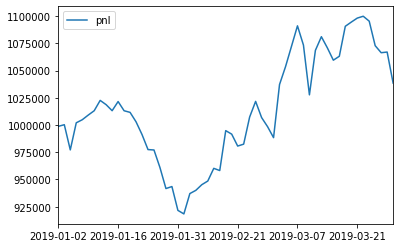

In [178]:
sample1 = HighFrequencyTrade(1000000,minute_close)
sample1.factor178Matrix = Factor178matrix;
sample1.run()

In [172]:
factor178position = pd.DataFrame(sample1.allPosition)
factor178position = factor178position.T
factor178position
outputpath='C:/Users/hw/Desktop/module1/BigDataAnalysis/homework/ASSIGNMENT3/178position.csv'
factor178position.to_csv(outputpath,sep=',',index=False,header=False)

In [152]:
sample2 = HighFrequencyTrade(1000000,minute_close)
sample2.getSkewness(minute_close,deal_minute_close,3)








  0%|                                                                                         | 0/1449 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars







  0%|                                                                                 | 1/1449 [00:02<52:45,  2.19s/it]






  0%|                                                                                 | 2/1449 [00:04<52:39,  2.18s/it]






  0%|▏                                                                                | 3/1449 [00:06<53:00,  2.20s/it]






  0%|▏                                                                                | 4/1449 [00:08<52:40,  2.19s/it]






  0%|▎                                                                                | 5/1449 [00:10<52:28,  2.18s/it]






  0%|▎                                                                                | 6/1449 [00:13<52:01,  2.16s/it]


  4%|██▉                                                                             | 54/1449 [01:58<52:20,  2.25s/it]






  4%|███                                                                             | 55/1449 [02:00<52:56,  2.28s/it]






  4%|███                                                                             | 56/1449 [02:02<53:40,  2.31s/it]






  4%|███▏                                                                            | 57/1449 [02:05<53:27,  2.30s/it]






  4%|███▏                                                                            | 58/1449 [02:07<53:31,  2.31s/it]






  4%|███▎                                                                            | 59/1449 [02:09<52:49,  2.28s/it]






  4%|███▎                                                                            | 60/1449 [02:12<53:34,  2.31s/it]






  4%|███▎                                                                            | 61/1449 [02:14<55:10,  2.39s/it

  8%|█████▉                                                                         | 109/1449 [04:20<49:56,  2.24s/it]






  8%|█████▉                                                                         | 110/1449 [04:22<50:03,  2.24s/it]






  8%|██████                                                                         | 111/1449 [04:24<49:16,  2.21s/it]






  8%|██████                                                                         | 112/1449 [04:26<49:22,  2.22s/it]






  8%|██████▏                                                                        | 113/1449 [04:28<49:19,  2.22s/it]






  8%|██████▏                                                                        | 114/1449 [04:31<48:56,  2.20s/it]






  8%|██████▎                                                                        | 115/1449 [04:33<48:14,  2.17s/it]






  8%|██████▎                                                                        | 116/1449 [04:35<48:48,  2.20s/it

 11%|████████▉                                                                      | 164/1449 [06:21<47:57,  2.24s/it]






 11%|████████▉                                                                      | 165/1449 [06:23<47:33,  2.22s/it]






 11%|█████████                                                                      | 166/1449 [06:25<47:15,  2.21s/it]






 12%|█████████                                                                      | 167/1449 [06:27<47:25,  2.22s/it]






 12%|█████████▏                                                                     | 168/1449 [06:30<47:14,  2.21s/it]






 12%|█████████▏                                                                     | 169/1449 [06:32<47:35,  2.23s/it]






 12%|█████████▎                                                                     | 170/1449 [06:34<47:50,  2.24s/it]






 12%|█████████▎                                                                     | 171/1449 [06:36<47:49,  2.25s/it

 15%|███████████▉                                                                   | 219/1449 [08:30<45:36,  2.23s/it]






 15%|███████████▉                                                                   | 220/1449 [08:32<45:41,  2.23s/it]






 15%|████████████                                                                   | 221/1449 [08:34<45:22,  2.22s/it]






 15%|████████████                                                                   | 222/1449 [08:36<45:01,  2.20s/it]






 15%|████████████▏                                                                  | 223/1449 [08:39<44:57,  2.20s/it]






 15%|████████████▏                                                                  | 224/1449 [08:41<44:42,  2.19s/it]






 16%|████████████▎                                                                  | 225/1449 [08:43<44:28,  2.18s/it]






 16%|████████████▎                                                                  | 226/1449 [08:45<44:31,  2.18s/it

 19%|██████████████▉                                                                | 274/1449 [10:32<43:01,  2.20s/it]






 19%|██████████████▉                                                                | 275/1449 [10:34<42:40,  2.18s/it]






 19%|███████████████                                                                | 276/1449 [10:36<42:40,  2.18s/it]






 19%|███████████████                                                                | 277/1449 [10:38<42:31,  2.18s/it]






 19%|███████████████▏                                                               | 278/1449 [10:41<42:24,  2.17s/it]






 19%|███████████████▏                                                               | 279/1449 [10:43<42:09,  2.16s/it]






 19%|███████████████▎                                                               | 280/1449 [10:45<42:31,  2.18s/it]






 19%|███████████████▎                                                               | 281/1449 [10:47<42:21,  2.18s/it

 23%|█████████████████▉                                                             | 329/1449 [12:41<48:12,  2.58s/it]






 23%|█████████████████▉                                                             | 330/1449 [12:43<47:20,  2.54s/it]






 23%|██████████████████                                                             | 331/1449 [12:46<48:21,  2.60s/it]






 23%|██████████████████                                                             | 332/1449 [12:49<48:27,  2.60s/it]






 23%|██████████████████▏                                                            | 333/1449 [12:51<47:39,  2.56s/it]






 23%|██████████████████▏                                                            | 334/1449 [12:54<47:09,  2.54s/it]






 23%|██████████████████▎                                                            | 335/1449 [12:56<46:57,  2.53s/it]






 23%|██████████████████▎                                                            | 336/1449 [12:59<45:49,  2.47s/it

 27%|████████████████████▉                                                          | 384/1449 [14:44<39:04,  2.20s/it]






 27%|████████████████████▉                                                          | 385/1449 [14:46<39:11,  2.21s/it]






 27%|█████████████████████                                                          | 386/1449 [14:49<39:03,  2.21s/it]






 27%|█████████████████████                                                          | 387/1449 [14:51<38:24,  2.17s/it]






 27%|█████████████████████▏                                                         | 388/1449 [14:53<38:50,  2.20s/it]






 27%|█████████████████████▏                                                         | 389/1449 [14:55<38:42,  2.19s/it]






 27%|█████████████████████▎                                                         | 390/1449 [14:57<38:58,  2.21s/it]






 27%|█████████████████████▎                                                         | 391/1449 [15:00<39:27,  2.24s/it

 30%|███████████████████████▉                                                       | 439/1449 [16:51<37:23,  2.22s/it]






 30%|███████████████████████▉                                                       | 440/1449 [16:53<37:18,  2.22s/it]






 30%|████████████████████████                                                       | 441/1449 [16:55<37:19,  2.22s/it]






 31%|████████████████████████                                                       | 442/1449 [16:58<37:25,  2.23s/it]






 31%|████████████████████████▏                                                      | 443/1449 [17:00<38:02,  2.27s/it]






 31%|████████████████████████▏                                                      | 444/1449 [17:02<38:26,  2.30s/it]






 31%|████████████████████████▎                                                      | 445/1449 [17:05<39:07,  2.34s/it]






 31%|████████████████████████▎                                                      | 446/1449 [17:07<39:30,  2.36s/it

 34%|██████████████████████████▉                                                    | 494/1449 [18:59<34:53,  2.19s/it]






 34%|██████████████████████████▉                                                    | 495/1449 [19:01<34:38,  2.18s/it]






 34%|███████████████████████████                                                    | 496/1449 [19:04<35:28,  2.23s/it]






 34%|███████████████████████████                                                    | 497/1449 [19:06<35:19,  2.23s/it]






 34%|███████████████████████████▏                                                   | 498/1449 [19:08<35:20,  2.23s/it]






 34%|███████████████████████████▏                                                   | 499/1449 [19:11<35:20,  2.23s/it]






 35%|███████████████████████████▎                                                   | 500/1449 [19:13<35:11,  2.23s/it]






 35%|███████████████████████████▎                                                   | 501/1449 [19:15<35:07,  2.22s/it

 38%|█████████████████████████████▉                                                 | 549/1449 [21:03<33:25,  2.23s/it]






 38%|█████████████████████████████▉                                                 | 550/1449 [21:05<33:38,  2.25s/it]






 38%|██████████████████████████████                                                 | 551/1449 [21:07<33:39,  2.25s/it]






 38%|██████████████████████████████                                                 | 552/1449 [21:09<33:02,  2.21s/it]






 38%|██████████████████████████████▏                                                | 553/1449 [21:11<32:51,  2.20s/it]






 38%|██████████████████████████████▏                                                | 554/1449 [21:14<32:55,  2.21s/it]






 38%|██████████████████████████████▎                                                | 555/1449 [21:16<32:49,  2.20s/it]






 38%|██████████████████████████████▎                                                | 556/1449 [21:18<32:25,  2.18s/it

 42%|████████████████████████████████▉                                              | 604/1449 [23:10<31:44,  2.25s/it]






 42%|████████████████████████████████▉                                              | 605/1449 [23:12<32:18,  2.30s/it]






 42%|█████████████████████████████████                                              | 606/1449 [23:15<32:13,  2.29s/it]






 42%|█████████████████████████████████                                              | 607/1449 [23:17<31:54,  2.27s/it]






 42%|█████████████████████████████████▏                                             | 608/1449 [23:19<31:26,  2.24s/it]






 42%|█████████████████████████████████▏                                             | 609/1449 [23:21<31:40,  2.26s/it]






 42%|█████████████████████████████████▎                                             | 610/1449 [23:24<31:09,  2.23s/it]






 42%|█████████████████████████████████▎                                             | 611/1449 [23:26<30:50,  2.21s/it

 45%|███████████████████████████████████▉                                           | 659/1449 [25:12<29:14,  2.22s/it]






 46%|███████████████████████████████████▉                                           | 660/1449 [25:15<29:07,  2.22s/it]






 46%|████████████████████████████████████                                           | 661/1449 [25:17<29:18,  2.23s/it]






 46%|████████████████████████████████████                                           | 662/1449 [25:19<29:15,  2.23s/it]






 46%|████████████████████████████████████▏                                          | 663/1449 [25:21<28:55,  2.21s/it]






 46%|████████████████████████████████████▏                                          | 664/1449 [25:23<28:54,  2.21s/it]






 46%|████████████████████████████████████▎                                          | 665/1449 [25:26<29:01,  2.22s/it]






 46%|████████████████████████████████████▎                                          | 666/1449 [25:28<28:52,  2.21s/it

 49%|██████████████████████████████████████▉                                        | 714/1449 [27:16<30:27,  2.49s/it]






 49%|██████████████████████████████████████▉                                        | 715/1449 [27:18<31:08,  2.55s/it]






 49%|███████████████████████████████████████                                        | 716/1449 [27:21<31:58,  2.62s/it]






 49%|███████████████████████████████████████                                        | 717/1449 [27:24<31:25,  2.58s/it]






 50%|███████████████████████████████████████▏                                       | 718/1449 [27:26<30:59,  2.54s/it]






 50%|███████████████████████████████████████▏                                       | 719/1449 [27:29<30:51,  2.54s/it]






 50%|███████████████████████████████████████▎                                       | 720/1449 [27:31<31:36,  2.60s/it]






 50%|███████████████████████████████████████▎                                       | 721/1449 [27:34<31:24,  2.59s/it

 53%|█████████████████████████████████████████▉                                     | 769/1449 [29:25<29:52,  2.64s/it]






 53%|█████████████████████████████████████████▉                                     | 770/1449 [29:28<28:10,  2.49s/it]






 53%|██████████████████████████████████████████                                     | 771/1449 [29:30<27:25,  2.43s/it]






 53%|██████████████████████████████████████████                                     | 772/1449 [29:32<26:52,  2.38s/it]






 53%|██████████████████████████████████████████▏                                    | 773/1449 [29:34<26:39,  2.37s/it]






 53%|██████████████████████████████████████████▏                                    | 774/1449 [29:38<29:17,  2.60s/it]






 53%|██████████████████████████████████████████▎                                    | 775/1449 [29:43<39:24,  3.51s/it]






 54%|██████████████████████████████████████████▎                                    | 776/1449 [29:49<47:50,  4.27s/it

 57%|████████████████████████████████████████████▉                                  | 824/1449 [32:12<25:50,  2.48s/it]






 57%|████████████████████████████████████████████▉                                  | 825/1449 [32:15<26:24,  2.54s/it]






 57%|█████████████████████████████████████████████                                  | 826/1449 [32:17<26:52,  2.59s/it]






 57%|█████████████████████████████████████████████                                  | 827/1449 [32:20<27:11,  2.62s/it]






 57%|█████████████████████████████████████████████▏                                 | 828/1449 [32:23<27:26,  2.65s/it]






 57%|█████████████████████████████████████████████▏                                 | 829/1449 [32:25<26:56,  2.61s/it]






 57%|█████████████████████████████████████████████▎                                 | 830/1449 [32:28<26:30,  2.57s/it]






 57%|█████████████████████████████████████████████▎                                 | 831/1449 [32:30<26:27,  2.57s/it

 61%|███████████████████████████████████████████████▉                               | 879/1449 [34:20<21:01,  2.21s/it]






 61%|███████████████████████████████████████████████▉                               | 880/1449 [34:23<20:57,  2.21s/it]






 61%|████████████████████████████████████████████████                               | 881/1449 [34:25<21:00,  2.22s/it]






 61%|████████████████████████████████████████████████                               | 882/1449 [34:27<20:58,  2.22s/it]






 61%|████████████████████████████████████████████████▏                              | 883/1449 [34:29<21:09,  2.24s/it]






 61%|████████████████████████████████████████████████▏                              | 884/1449 [34:32<21:13,  2.25s/it]






 61%|████████████████████████████████████████████████▎                              | 885/1449 [34:34<20:54,  2.22s/it]






 61%|████████████████████████████████████████████████▎                              | 886/1449 [34:36<20:43,  2.21s/it

 64%|██████████████████████████████████████████████████▉                            | 934/1449 [36:23<19:00,  2.21s/it]






 65%|██████████████████████████████████████████████████▉                            | 935/1449 [36:25<18:59,  2.22s/it]






 65%|███████████████████████████████████████████████████                            | 936/1449 [36:27<18:54,  2.21s/it]






 65%|███████████████████████████████████████████████████                            | 937/1449 [36:29<18:49,  2.21s/it]






 65%|███████████████████████████████████████████████████▏                           | 938/1449 [36:31<18:49,  2.21s/it]






 65%|███████████████████████████████████████████████████▏                           | 939/1449 [36:34<19:20,  2.27s/it]






 65%|███████████████████████████████████████████████████▏                           | 940/1449 [36:36<19:16,  2.27s/it]






 65%|███████████████████████████████████████████████████▎                           | 941/1449 [36:38<19:07,  2.26s/it

 68%|█████████████████████████████████████████████████████▉                         | 989/1449 [38:32<17:08,  2.24s/it]






 68%|█████████████████████████████████████████████████████▉                         | 990/1449 [38:34<17:11,  2.25s/it]






 68%|██████████████████████████████████████████████████████                         | 991/1449 [38:37<17:07,  2.24s/it]






 68%|██████████████████████████████████████████████████████                         | 992/1449 [38:39<16:59,  2.23s/it]






 69%|██████████████████████████████████████████████████████▏                        | 993/1449 [38:41<17:02,  2.24s/it]






 69%|██████████████████████████████████████████████████████▏                        | 994/1449 [38:43<17:06,  2.26s/it]






 69%|██████████████████████████████████████████████████████▏                        | 995/1449 [38:46<17:07,  2.26s/it]






 69%|██████████████████████████████████████████████████████▎                        | 996/1449 [38:48<17:13,  2.28s/it

 72%|████████████████████████████████████████████████████████▏                     | 1044/1449 [40:36<15:01,  2.23s/it]






 72%|████████████████████████████████████████████████████████▎                     | 1045/1449 [40:38<14:58,  2.22s/it]






 72%|████████████████████████████████████████████████████████▎                     | 1046/1449 [40:40<14:47,  2.20s/it]






 72%|████████████████████████████████████████████████████████▎                     | 1047/1449 [40:43<15:03,  2.25s/it]






 72%|████████████████████████████████████████████████████████▍                     | 1048/1449 [40:45<14:55,  2.23s/it]






 72%|████████████████████████████████████████████████████████▍                     | 1049/1449 [40:47<14:44,  2.21s/it]






 72%|████████████████████████████████████████████████████████▌                     | 1050/1449 [40:49<14:43,  2.21s/it]






 73%|████████████████████████████████████████████████████████▌                     | 1051/1449 [40:52<14:48,  2.23s/it

 76%|███████████████████████████████████████████████████████████▏                  | 1099/1449 [42:46<15:06,  2.59s/it]






 76%|███████████████████████████████████████████████████████████▏                  | 1100/1449 [42:48<14:56,  2.57s/it]






 76%|███████████████████████████████████████████████████████████▎                  | 1101/1449 [42:51<14:49,  2.56s/it]






 76%|███████████████████████████████████████████████████████████▎                  | 1102/1449 [42:53<15:07,  2.62s/it]






 76%|███████████████████████████████████████████████████████████▎                  | 1103/1449 [42:56<14:46,  2.56s/it]






 76%|███████████████████████████████████████████████████████████▍                  | 1104/1449 [42:58<14:06,  2.45s/it]






 76%|███████████████████████████████████████████████████████████▍                  | 1105/1449 [43:00<13:57,  2.43s/it]






 76%|███████████████████████████████████████████████████████████▌                  | 1106/1449 [43:03<13:38,  2.39s/it

 80%|██████████████████████████████████████████████████████████████                | 1154/1449 [44:50<11:06,  2.26s/it]






 80%|██████████████████████████████████████████████████████████████▏               | 1155/1449 [44:52<10:59,  2.24s/it]






 80%|██████████████████████████████████████████████████████████████▏               | 1156/1449 [44:54<10:50,  2.22s/it]






 80%|██████████████████████████████████████████████████████████████▎               | 1157/1449 [44:56<10:48,  2.22s/it]






 80%|██████████████████████████████████████████████████████████████▎               | 1158/1449 [44:59<10:47,  2.23s/it]






 80%|██████████████████████████████████████████████████████████████▍               | 1159/1449 [45:01<10:40,  2.21s/it]






 80%|██████████████████████████████████████████████████████████████▍               | 1160/1449 [45:03<10:42,  2.22s/it]






 80%|██████████████████████████████████████████████████████████████▍               | 1161/1449 [45:05<10:45,  2.24s/it

 83%|█████████████████████████████████████████████████████████████████             | 1209/1449 [46:53<09:00,  2.25s/it]






 84%|█████████████████████████████████████████████████████████████████▏            | 1210/1449 [46:56<09:07,  2.29s/it]






 84%|█████████████████████████████████████████████████████████████████▏            | 1211/1449 [46:58<09:06,  2.30s/it]






 84%|█████████████████████████████████████████████████████████████████▏            | 1212/1449 [47:00<09:11,  2.33s/it]






 84%|█████████████████████████████████████████████████████████████████▎            | 1213/1449 [47:03<09:07,  2.32s/it]






 84%|█████████████████████████████████████████████████████████████████▎            | 1214/1449 [47:05<09:01,  2.30s/it]






 84%|█████████████████████████████████████████████████████████████████▍            | 1215/1449 [47:07<08:54,  2.28s/it]






 84%|█████████████████████████████████████████████████████████████████▍            | 1216/1449 [47:10<08:54,  2.29s/it

 87%|████████████████████████████████████████████████████████████████████          | 1264/1449 [49:03<06:53,  2.23s/it]






 87%|████████████████████████████████████████████████████████████████████          | 1265/1449 [49:05<06:55,  2.26s/it]






 87%|████████████████████████████████████████████████████████████████████▏         | 1266/1449 [49:07<06:57,  2.28s/it]






 87%|████████████████████████████████████████████████████████████████████▏         | 1267/1449 [49:10<06:55,  2.28s/it]






 88%|████████████████████████████████████████████████████████████████████▎         | 1268/1449 [49:12<06:44,  2.23s/it]






 88%|████████████████████████████████████████████████████████████████████▎         | 1269/1449 [49:14<06:45,  2.25s/it]






 88%|████████████████████████████████████████████████████████████████████▎         | 1270/1449 [49:16<06:45,  2.27s/it]






 88%|████████████████████████████████████████████████████████████████████▍         | 1271/1449 [49:18<06:41,  2.26s/it

 91%|███████████████████████████████████████████████████████████████████████       | 1319/1449 [51:07<04:53,  2.26s/it]






 91%|███████████████████████████████████████████████████████████████████████       | 1320/1449 [51:09<04:45,  2.22s/it]






 91%|███████████████████████████████████████████████████████████████████████       | 1321/1449 [51:11<04:45,  2.23s/it]






 91%|███████████████████████████████████████████████████████████████████████▏      | 1322/1449 [51:13<04:38,  2.20s/it]






 91%|███████████████████████████████████████████████████████████████████████▏      | 1323/1449 [51:16<04:46,  2.27s/it]






 91%|███████████████████████████████████████████████████████████████████████▎      | 1324/1449 [51:18<04:39,  2.23s/it]






 91%|███████████████████████████████████████████████████████████████████████▎      | 1325/1449 [51:20<04:37,  2.23s/it]






 92%|███████████████████████████████████████████████████████████████████████▍      | 1326/1449 [51:22<04:33,  2.22s/it

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1374/1449 [53:19<02:50,  2.27s/it]






 95%|██████████████████████████████████████████████████████████████████████████    | 1375/1449 [53:21<02:44,  2.22s/it]






 95%|██████████████████████████████████████████████████████████████████████████    | 1376/1449 [53:23<02:41,  2.21s/it]






 95%|██████████████████████████████████████████████████████████████████████████    | 1377/1449 [53:26<02:39,  2.22s/it]






 95%|██████████████████████████████████████████████████████████████████████████▏   | 1378/1449 [53:28<02:38,  2.23s/it]






 95%|██████████████████████████████████████████████████████████████████████████▏   | 1379/1449 [53:30<02:36,  2.23s/it]






 95%|██████████████████████████████████████████████████████████████████████████▎   | 1380/1449 [53:32<02:32,  2.21s/it]






 95%|██████████████████████████████████████████████████████████████████████████▎   | 1381/1449 [53:34<02:32,  2.24s/it

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1429/1449 [55:22<00:44,  2.23s/it]






 99%|████████████████████████████████████████████████████████████████████████████▉ | 1430/1449 [55:24<00:41,  2.21s/it]






 99%|█████████████████████████████████████████████████████████████████████████████ | 1431/1449 [55:26<00:39,  2.20s/it]






 99%|█████████████████████████████████████████████████████████████████████████████ | 1432/1449 [55:28<00:37,  2.22s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▏| 1433/1449 [55:31<00:35,  2.20s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▏| 1434/1449 [55:33<00:33,  2.24s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▏| 1435/1449 [55:35<00:30,  2.20s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▎| 1436/1449 [55:37<00:28,  2.18s/it

IndexError: single positional indexer is out-of-bounds

In [158]:
ss = sample2.Skewness.iloc[200,:]
ss

600458    0.0
600568    0.0
600732    0.0
600833    0.0
601163    0.0
         ... 
600535    0.0
600877    0.0
601798    0.0
603227    0.0
600331    0.0
Name: 2019-03-21 10:00:00, Length: 1449, dtype: float64

{Timestamp('2019-01-02 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-03 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-04 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-07 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-08 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-09 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-10 10:00:00'): ['600458', '600568', '600732', '600833', '601163', '600735', '600129', '603558', '601838', '603980'], Timestamp('2019-01-11 10:00:00'): ['600458', '6

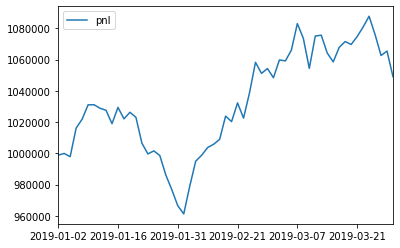

In [ ]:
sample3 = HighFrequencyTrade(1000000,minute_close)
sample3.Skewness = sample2.Skewness.fillna('pad')
sample3.run()